# SimPy Tutorial 1: Fundamentals of Discrete Event Simulation

This tutorial introduces key SimPy concepts and demonstrates how to simulate a basic queue system. You'll learn about:
- **Environment**: The simulation context
- **Process**: Actions that occur over time
- **Resources**: Shared, limited capacity objects
- **Monitoring**: Recording key statistics 
- **Queue Simulation**: Putting it all together

The tutorial includes code demonstration and "Try It Yourself" tasks which you should attempt to do. Please work with other students if you wish and ask the tutor for guidance if you struggle.

[SimPy](https://simpy.readthedocs.io/) is a process-based discrete-event simulation framework based on standard Python.

## 1. Installation and Setup

First, let's import the necessary libraries.

In [13]:
# simpy is not installed by default on the lab computers so we need to do that first
import sys
!{sys.executable} -m pip install simpy
#import key libraries
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

## 2. SimPy Environment

The **Environment** is the core of SimPy. It manages the simulation time and schedules events.

Let's create a simple environment and run it:

In [3]:
# Create a SimPy environment
env = simpy.Environment()

# Check the current simulation time
print(f"Initial simulation time: {env.now}")

# Run the simulation for 10 time units
env.run(until=10)

print(f"Simulation time after running: {env.now}")

Initial simulation time: 0
Simulation time after running: 10


#### Try It Yourself

1. Modify the code above to run the simulation for an additional 10 time units. Check the final simulation time.
2. Run an additional timeout event `env.run(until=env.timeout(10))` and check the final simulation time again.


## 3. Processes

A **Process** is a function that describes events happening over time. Processes use Python's generator functions (with `yield`) to interact with the simulation.

### 3.1 Simple Process with Timeout

Let's create a process that prints messages at different times:

In [4]:
def my_process(env, name, duration):
    """A simple process that waits for a specified duration."""
    print(f"{env.now}: {name} starting")
    
    # Wait for the specified duration
    yield env.timeout(duration)
    
    print(f"{env.now}: {name} finished after {duration} time units")

# Create environment
env = simpy.Environment()

# Start the process
env.process(my_process(env, "Process A", 5))
env.process(my_process(env, "Process B", 3))

# Run simulation
env.run()

0: Process A starting
0: Process B starting
3: Process B finished after 3 time units
5: Process A finished after 5 time units


#### Try It Yourself

1. Add a third process called "Process C" that runs for 7 time units. Observe the order in which the processes finish.
2. Create a loop that will generate N instances of `my_process` with unique names (e.g. `f'Process {num}'`) and process times randomly generated (e.g. using `random.randint(1, 7)`).


### 3.2 Multiple Activities in a Process

A process can have multiple activities (timeouts) in sequence:

In [5]:
def car_journey(env, name):
    """Simulate a car journey with multiple stages."""
    print(f"{env.now}: {name} starts driving")
    
    # Drive to petrol station
    yield env.timeout(2)
    print(f"{env.now}: {name} arrives at petrol station")
    
    # Refuel
    yield env.timeout(1)
    print(f"{env.now}: {name} finishes refuelling")
    
    # Drive to destination
    yield env.timeout(3)
    print(f"{env.now}: {name} arrives at destination")

# Create and run simulation
env = simpy.Environment()
env.process(car_journey(env, "Car 1"))
env.run()


0: Car 1 starts driving
2: Car 1 arrives at petrol station
3: Car 1 finishes refuelling
6: Car 1 arrives at destination


#### Try It Yourself

1. Modify the `car_journey` function to add a fourth stage: stopping at a rest area for 0.5 time units before reaching the destination. Run the simulation and verify the total journey time increases accordingly.

## 4. Resources

A **Resource** represents something with limited capacity that processes need to use (e.g., servers, machines, parking spaces). Processes must request access to a resource and may have to wait if it is busy.

In [6]:
def user(env, name, server):
    """A user tries to use a shared server."""
    print(f"{env.now}: {name} arrives and requests server")
    
    # Request the resource
    with server.request() as request:
        # Wait until the resource is available
        yield request
        print(f"{env.now}: {name} got the server")
        
        # Use the resource for some time
        yield env.timeout(2)
        print(f"{env.now}: {name} releases the server")

# Create environment and a single server resource
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)

# Start multiple users
env.process(user(env, "User A", server))
env.run(until=env.timeout(3))
env.process(user(env, "User B", server))
env.run(until=env.timeout(3))
env.process(user(env, "User C", server))

# Run simulation
env.run()

0: User A arrives and requests server
0: User A got the server
2: User A releases the server
3: User B arrives and requests server
3: User B got the server
5: User B releases the server
6: User C arrives and requests server
6: User C got the server
8: User C releases the server


Notice how User B and User C had to wait because the server was busy with the previous user. This is the essence of queueing!

#### Try It Yourself

1. Change the server capacity from 1 to 2 and run the simulation again. How does the behaviour change? Do any users still have to wait?
2. At the moment all users arrive at time = 0. Add staggered arrivals by advancing the simulation by a short interval between each process (e.g. by adding `env.run(until=env.timeout(0.5))`). Check the timing for each user arrival and departure. Has the waiting time of each user changed?


## 5. Monitoring

Before building a complete queue simulation, it is essential to understand how to collect and monitor performance metrics. This section covers different approaches to gathering simulation data.

### 5.1 Collecting Event Data

A simple way to collect event data is by using a dictionary to store different metrics. Let's track wait times and queue lengths:


In [7]:
def user_with_stats(env, name, server, stats):
    """A user that records wait time and queue length."""
    arrival_time = env.now
    print(f"{env.now:.2f}: {name} arrives")
    
    # Log queue length and server utilisation at arrival
    # we store both time and metric (as a tuple e.g. (time, queue_length))
    stats['queue_lengths'].append((env.now, len(server.queue))) 
    stats['utilisation'].append((env.now, server.count / server.capacity))
    
    with server.request() as request:
        # Wait for the resource
        yield request
        
        # Calculate and record wait time
        wait_time = env.now - arrival_time
        stats['wait_times'].append(wait_time)
        print(f"{env.now:.2f}: {name} got server (waited {wait_time:.2f})")
        
        # Use the resource
        yield env.timeout(2)
        print(f"{env.now:.2f}: {name} releases server")

        # Log queue length and server utilisation after finishing
        stats['queue_lengths'].append((env.now, len(server.queue))) 
        stats['utilisation'].append((env.now, server.count / server.capacity))

# Create environment and resources
env = simpy.Environment()
server = simpy.Resource(env, capacity=1)
stats = {
    'wait_times': [],
    'queue_lengths': [],
    'utilisation': []
}

# Start multiple users
env.process(user_with_stats(env, "User A", server, stats))
env.process(user_with_stats(env, "User B", server, stats))
env.process(user_with_stats(env, "User C", server, stats))

# Run simulation
env.run()


0.00: User A arrives
0.00: User B arrives
0.00: User C arrives
0.00: User A got server (waited 0.00)
2.00: User A releases server
2.00: User B got server (waited 2.00)
4.00: User B releases server
4.00: User C got server (waited 4.00)
6.00: User C releases server


### 5.2 Statistical Analysis

Now let us analyse the collected metrics:


In [8]:
def weighted_average(time_value_pairs):
    """Calculate weighted average from time-value pairs."""
    times, values = zip(*time_value_pairs)  # Unzip times and values into separate lists
    durations = np.diff(np.array(times, dtype=float))  # Convert to float and get differences/durations
    durations /= np.sum(durations)  # Normalise to get time proportions
    weighted_avg = np.sum(values[:-1] * durations)  # Weighted average
    return weighted_avg

print("\n" + "="*60)
print("QUEUE STATISTICS")
print("="*60)

print(f" Total simulation time: {env.now:.2f} time units")
print(f" Total customers served: {len(stats['wait_times'])}")


# Wait Time Statistics
print(f"\nWAIT TIME:")
print(f" Average: {sum(stats['wait_times']) / len(stats['wait_times']):.2f} time units")

# Queue Length Statistics
print(f"\nQUEUE LENGTH:")
print(f" Average: {weighted_average(stats['queue_lengths']):.2f} customers")
q_time, q_value = zip(*stats['queue_lengths'])  # Unzip times and values into separate lists
print(f" Maximum: {max(q_value):.0f} customers")

# Utilisation Statistics
print(f"\nSERVER UTILISATION:")
print(f" Average: {weighted_average(stats['utilisation']):.2f}")

print("="*60)



QUEUE STATISTICS
 Total simulation time: 6.00 time units
 Total customers served: 3

WAIT TIME:
 Average: 2.00 time units

QUEUE LENGTH:
 Average: 1.33 customers
 Maximum: 2 customers

SERVER UTILISATION:
 Average: 1.00


**Key Insight**: By using a dictionary to store different metrics, we can collect multiple types of data throughout the simulation and analyse them afterwards. This technique scales well for complex simulations with many performance indicators.


#### Try It Yourself

1. Add a fourth user (User D) that arrives at the same time as User A. Run the simulation and examine all performance metrics. What patterns do you notice?
2. Stagger the arrivals in a similar way as in the previous task. How did that affect the performance results?
3. Find the arrival times so that the utilisation drops below 100%.
4. Calculate the arrival time statistics and maximum queue length using `numpy` (check the lecture slides for reference).


## 6. Complete Queue Simulation

Now let's put everything together to create a realistic queue simulation with:
- Random arrival times (exponential distribution)
- Random service times (exponential distribution)
- Comprehensive statistics tracking (wait times, queue length, utilisation)

### 6.1 Define the Customer Process


In [9]:
def customer(env, name, server, service_time, stats):
    """
    Represents a customer arriving, waiting, being served, and leaving.
    
    Args:
        env: SimPy environment
        name: Customer identifier
        server: Resource instance
        service_time: Time required for service
        stats: Dictionary containing lists for different metrics
    """
    arrival_time = env.now
    
    # Log queue length and server utilisation at arrival
    stats['queue_lengths'].append((env.now, len(server.queue))) 
    stats['utilisation'].append((env.now, server.count / server.capacity))
    
    with server.request() as request:
        # Wait in queue (server.request() automatically logs utilisation)
        yield request
        wait_time = env.now - arrival_time
        stats['wait_times'].append(wait_time)
        
        # Being served
        yield env.timeout(service_time)

        # Log queue length and server utilisation after finishing
        stats['queue_lengths'].append((env.now, len(server.queue))) 
        stats['utilisation'].append((env.now, server.count / server.capacity))


### 6.2 Define the Customer Generator

This creates a continuous stream of arriving customers:

In [10]:
def customer_generator(env, server, arrival_rate, service_rate, stats):
    """
    Generates customers arriving at the queue.
    
    Args:
        env: SimPy environment
        server: Resource instance
        arrival_rate: Average arrivals per time unit (lambda)
        service_rate: Average services per time unit (mu)
        stats: Dictionary to store statistics
    """
    customer_count = 0
    while True:
        # Wait for next arrival (exponentially distributed)
        yield env.timeout(random.expovariate(arrival_rate))
        
        # Create new customer
        customer_count += 1
        service_time = random.expovariate(service_rate)
        env.process(
            customer(env, f'Customer {customer_count}', server, 
                    service_time, stats)
        )

### 6.3 Run the Simulation

Let's set up and run the queue simulation with comprehensive statistics tracking:


In [11]:
# Simulation parameters
ARRIVAL_RATE = 1.0      # Average 1 customer per time unit
SERVICE_RATE = 1.2      # Average 1.2 customers served per time unit
SIMULATION_TIME = 20.0  # Run for 20 time units
SERVER_CAPACITY = 1    # Single server
# random.seed(42)         # For reproducibility

# Create environment and initialize statistics dictionary
env = simpy.Environment()
stats = {
    'wait_times': [],
    'queue_lengths': [],
    'utilisation': []
}

# Create Resource
server = simpy.Resource(env, capacity=SERVER_CAPACITY)

# Start the customer generator
env.process(
    customer_generator(env, server, ARRIVAL_RATE, SERVICE_RATE, stats)
)

# Run simulation
env.run(until=SIMULATION_TIME)


### 6.4 Analyse the Results

Let's examine the comprehensive statistics collected during the simulation:


In [16]:
def weighted_average(time_value_pairs):
    """Calculate weighted average from time-value pairs."""
    times, values = zip(*time_value_pairs)  # Unzip times and values into separate lists
    durations = np.diff(np.array(times, dtype=float))  # Convert to float and get differences/durations
    durations /= np.sum(durations)  # Normalise to get time proportions
    weighted_avg = np.sum(values[:-1] * durations)  # Weighted average
    return weighted_avg

q_time, q_value = zip(*stats['queue_lengths'])  # Unzip times and values into separate lists

summary_text = f"""
SIMULATION PARAMETERS
─────────────────────────
Number of Servers: {SERVER_CAPACITY}
Arrival Rate (λ): {ARRIVAL_RATE} customers/time unit
Service Rate (μ): {SERVICE_RATE} customers/time unit/server
Simulation Time: {env.now} time units

RESULTS
─────────────────────────
Total Customers Served: {len(stats['wait_times'])}

WAIT TIME
Average: {np.average(stats['wait_times']):.2f} time units
Maximum: {np.max(stats['wait_times']):.2f} time units

QUEUE LENGTH
Average: {weighted_average(stats['queue_lengths']):.2f} customers
Maximum: {np.max(q_value):.2f} customers

SERVER METRICS
Average Utilisation: {weighted_average(stats['utilisation']):.2f}%
"""
print(summary_text)


SIMULATION PARAMETERS
─────────────────────────
Number of Servers: 1
Arrival Rate (λ): 1.0 customers/time unit
Service Rate (μ): 1.2 customers/time unit/server
Simulation Time: 20.0 time units

RESULTS
─────────────────────────
Total Customers Served: 22

WAIT TIME
Average: 2.73 time units
Maximum: 6.77 time units

QUEUE LENGTH
Average: 3.43 customers
Maximum: 7.00 customers

SERVER METRICS
Average Utilisation: 0.88%



#### Try It Yourself

1. Run the simulation for 10 times longer duration. Compare the final results between the short and long simulation times. 
1. Run the long simulation 3 times and note the differences in simulation results.
1. Experiment with different arrival and service rates:
   - Change `ARRIVAL_RATE = 2.0` and `SERVICE_RATE = 1.5` (system overload – arrivals exceed service capacity)
   - Change `ARRIVAL_RATE = 0.5` and `SERVICE_RATE = 2.0` (system underload – plenty of spare capacity)

   Run the simulation for each scenario and compare the wait times, queue lengths, and utilisation. How do they differ from the original balanced scenario?


## 7. Key Takeaways

### SimPy Concepts Covered:

1. **Environment (`simpy.Environment()`)**: The simulation context that manages time and events
   - `env.now` – current simulation time
   - `env.run(until=X)` – run simulation until time X
   - `env.process()` – start a new process

2. **Process (generator functions with `yield`)**: Activities that occur over time
   - Use `yield env.timeout(t)` to wait for a duration
   - Use `yield request` to wait for a resource

3. **Resource (`simpy.Resource()`)**: Shared, limited capacity objects
   - `capacity` – number of simultaneous users allowed
   - `request()` – request access to the resource
   - Use `with resource.request() as request:` for automatic release

4. **Statistics Collection**: Allows for monitoring simulation performance
   - Standard and weighted statistics
   
### Queue Simulation Pattern:

```python
# 1. Create environment
env = simpy.Environment()

# 2. Create shared resources
server = simpy.Resource(env, capacity=1)

# 3. Define process functions with yield
def customer(env, name, server):
    yield env.timeout(...)  # activities
    with server.request() as req:
        yield req  # wait for resource
        yield env.timeout(...)  # use resource

def customer_generator(env, server, arrival_rate, service_rate):
    customer_count = 0
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        customer_count += 1
        service_time = random.expovariate(service_rate)
        env.process(customer(env, f'Customer {customer_count}', 
                            server, service_time))

# 4. Start processes
env.process(customer_generator(env, server, arrival_rate, service_rate))

# 5. Run simulation
env.run(until=TIME)
```

This pattern can be extended to model complex systems with multiple resource types, priorities, interruptions, and more!


## 8. Result Visualisation

This final section demonstrates how to visualise the simulation results using the Matplotlib library. It builds upon the complete queue simulation from Section 6 and creates comprehensive visual representations of the collected statistics.

**Note**: This section is optional and should be attempted only after completing all previous parts of the tutorial.


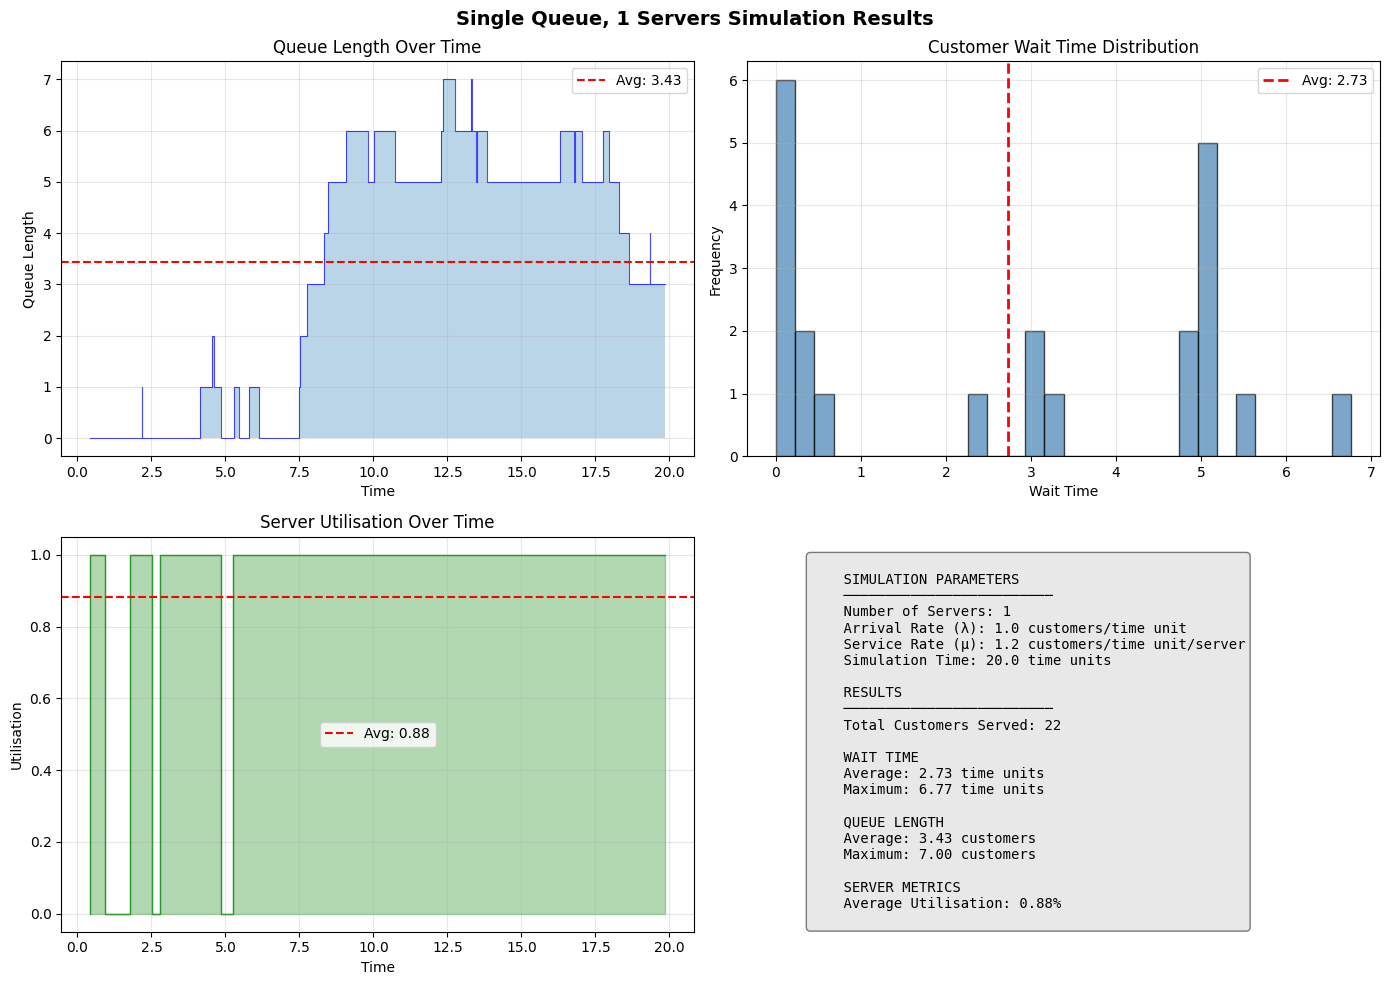

In [ ]:
def visualise_results(config, stats):
    """
    Create visualisations of the simulation results.
    
    Args:
        config: Simulation configuration dictionary with keys: 
                num_servers, arrival_rate, service_rate, simulation_time
        stats: Collected statistics from simulation containing:
               wait_times, queue_lengths, utilisation
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Single Queue, {config["num_servers"]} Server{"s" if config["num_servers"] > 1 else ""} Simulation Results',
                 fontsize=14, fontweight='bold')
    
    # Plot 1: Queue Length Over Time
    ax1 = axes[0, 0]
    times, lengths = zip(*stats['queue_lengths'])
    ax1.step(times, lengths, 'b-', alpha=0.7, linewidth=0.8)
    ax1.fill_between(times, lengths, step="pre", alpha=0.3)
    ax1.axhline(y=weighted_average(stats['queue_lengths']), color='r', linestyle='--', 
                label=f"Avg: {weighted_average(stats['queue_lengths']):.2f}")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Queue Length')
    ax1.set_title('Queue Length Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Wait Time Distribution
    ax2 = axes[0, 1]
    ax2.hist(stats['wait_times'], bins=30, edgecolor='black', alpha=0.7, 
             color='steelblue')
    ax2.axvline(x=np.average(stats['wait_times']), color='r', linestyle='--', 
                linewidth=2, label=f"Avg: {np.average(stats['wait_times']):.2f}")
    ax2.set_xlabel('Wait Time')
    ax2.set_ylabel('Frequency') 
    ax2.set_title('Customer Wait Time Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Server Utilisation Over Time
    ax3 = axes[1, 0]
    times_util, values_util = zip(*stats['utilisation'])
    ax3.step(times_util, values_util, 'g-', alpha=0.7, linewidth=1)
    ax3.fill_between(times_util, values_util, step="pre", alpha=0.3, color='green')
    ax3.axhline(y=weighted_average(stats['utilisation']), color='r', linestyle='--',
                label=f"Avg: {weighted_average(stats['utilisation']):.2f}")
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Utilisation')
    ax3.set_title('Server Utilisation Over Time')
    ax3.set_ylim(-0.05, 1.05)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Summary Statistics (Text)
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    q_time, q_value = zip(*stats['queue_lengths'])
    
    summary_text = f"""
    SIMULATION PARAMETERS
    ─────────────────────────
    Number of Servers: {config['num_servers']}
    Arrival Rate (λ): {config['arrival_rate']} customers/time unit
    Service Rate (μ): {config['service_rate']} customers/time unit/server
    Simulation Time: {config['simulation_time']} time units
    
    RESULTS
    ─────────────────────────
    Total Customers Served: {len(stats['wait_times'])}

    WAIT TIME
    Average: {np.average(stats['wait_times']):.2f} time units
    Maximum: {np.max(stats['wait_times']):.2f} time units

    QUEUE LENGTH
    Average: {weighted_average(stats['queue_lengths']):.2f} customers
    Maximum: {np.max(q_value):.0f} customers

    SERVER METRICS
    Average Utilisation: {weighted_average(stats['utilisation']) * 100:.1f}%
    """
    
    ax4.text(0.1, 0.95, summary_text, transform=ax4.transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
  
# Create configuration dictionary for visualisation
config = {
    'num_servers': SERVER_CAPACITY,
    'arrival_rate': ARRIVAL_RATE,
    'service_rate': SERVICE_RATE,
    'simulation_time': SIMULATION_TIME       
}

# Generate visualisation
visualise_results(config, stats)


#### Try It Yourself

1. Compare visually the final results between the short and long simulation times.
1. Compare visually the final results between the underload, balanced and overload service capacity.
